# Data Splitting for Semi-Automatic Label Generation

This notebook creates a representative sample for the semi-automatic label generation method. It prepares and analyzes CT colonography metadata, including filtering, merging, and demographic statistics. Stratified sampling ensures balanced representation by gender, age, and manufacturer, and the resulting distributions are visualized for quality control.

In [2]:
import pandas as pd

In [18]:
metadata_tcia = pd.read_excel("data/metadata_tcia.xlsx")
metadata_ku = pd.read_json("data/metadata_ku.json", lines=True)

### Data exploration

In [19]:
# get Patient Sex count of data
group_by_patient = metadata_tcia.groupby('Patient ID').first().reset_index()
sex_counts = group_by_patient['Patient Sex'].value_counts()
sex_counts

Patient Sex
F    401
M    353
U     19
O     12
Name: count, dtype: int64

In [20]:
# count unknown values per column
unknown_counts = metadata_tcia.isnull().sum()
unknown_counts = unknown_counts[unknown_counts > 0]
print("Unknown values per column:")
print(unknown_counts)

Unknown values per column:
Patient Birth Date                         3451
Patient Sex                                 202
Ethnic Group                               3451
Study Description                           204
Admitting Diagnosis Description            3404
Study ID                                    194
Patient Age                                 429
Longitudinal Temporal Event Type           3451
Longitudinal Temporal Offset From Event    3451
Protocol Name                               261
Series Date                                 328
Series Description                          250
Annotations Flag                           3451
Manufacturer                                202
Manufacturer Model Name                     202
Software Versions                           203
Third Party Analysis                       3451
dtype: int64


In [21]:
# merge dataframes by 'Study Instance UID' and 'InstanceUID'
merged_data = pd.merge(metadata_tcia, metadata_ku, left_on='Series Instance UID', right_on='InstanceUID', how='inner')
# Display the first few rows of the merged data
print(merged_data.shape)
merged_data.head(2)


(1714, 61)


,Patient ID,Patient Name,Patient Birth Date,Patient Sex,Ethnic Group,Phantom,Species Code,Species Description,Study Instance UID,Study Date,...,patients_age,slice_location,gender,new_sub_id,scan,position,mha_path,dicom_path,split,segmentation_path
0,1.3.6.1.4.1.9328.50.4.0001,1.3.6.1.4.1.9328.50.4.0001,NaN,F,NaN,NO,337915000,Homo sapiens,1.3.6.1.4.1.9328.50.4.1,2000-01-01 00:00:00.0,...,59.0,551.9,F,sub001,1,prone,converted/sub001/sub001_pos-prone_scan-1_conv-...,raw/sub001/sub001_pos-prone_scan-1.zip,None,None
1,1.3.6.1.4.1.9328.50.4.0001,1.3.6.1.4.1.9328.50.4.0001,NaN,F,NaN,NO,337915000,Homo sapiens,1.3.6.1.4.1.9328.50.4.1,2000-01-01 00:00:00.0,...,59.0,562.2,F,sub001,1,supine,converted/sub001/sub001_pos-supine_scan-1_conv...,raw/sub001/sub001_pos-supine_scan-1.zip,test,segmentations/segmentations-regionalgrowing-qc...


In [22]:
# only keep ffs, ffp, and hfs, hfp
def filter_position(position):
    if position in ['FFS', 'FFP', 'HFS', 'HFP']:
        return position
    else:
        return None
merged_data['patient_position'] = merged_data['patient_position'].apply(filter_position)
# Drop rows with None values in 'patient_position'
merged_data = merged_data[merged_data['patient_position'].notnull()]

print(merged_data.shape)

(1666, 61)


In [23]:
# count unknown values per column
unknown_counts = merged_data.isnull().sum()
unknown_counts = unknown_counts[unknown_counts > 0]
print("Unknown values per column:")
print(unknown_counts)

Unknown values per column:
Patient Birth Date                         1666
Patient Sex                                  83
Ethnic Group                               1666
Study Description                            85
Admitting Diagnosis Description            1642
Study ID                                     80
Patient Age                                 199
Longitudinal Temporal Event Type           1666
Longitudinal Temporal Offset From Event    1666
Protocol Name                               112
Series Date                                 140
Series Description                          106
Annotations Flag                           1666
Manufacturer                                 83
Manufacturer Model Name                      83
Software Versions                            84
Third Party Analysis                       1666
filename                                      5
volume                                        5
surface                                       5
time         

In [24]:
# min max age
merged_data = merged_data[merged_data['Patient Age'].notnull()]
min_age = merged_data['Patient Age'].min()
max_age = merged_data['Patient Age'].max()
print(f"Min age: {min_age}")
print(f"Max age: {max_age}")

Min age: 009Y
Max age: 110Y


In [25]:
# Extract numeric part from 'Patient Age' and convert to integers
merged_data['Patient Age'] = merged_data['Patient Age'].str.extract(r'(\d+)').astype(int)

# Keep only rows where 'Patient Age' is between 50 and 90
merged_data = merged_data[(merged_data['Patient Age'] >= 50) & (merged_data['Patient Age'] <= 90)]
# Print the shape of the filtered DataFrame
print(merged_data.shape)

(1401, 61)


In [26]:
# count unknown values per column
unknown_counts = merged_data.isnull().sum()
unknown_counts = unknown_counts[unknown_counts > 0]
print("Unknown values per column:")
print(unknown_counts)

Unknown values per column:
Patient Birth Date                         1401
Ethnic Group                               1401
Study Description                             2
Admitting Diagnosis Description            1401
Longitudinal Temporal Event Type           1401
Longitudinal Temporal Offset From Event    1401
Protocol Name                                29
Series Date                                  57
Series Description                           23
Annotations Flag                           1401
Software Versions                             1
Third Party Analysis                       1401
filename                                      3
volume                                        3
surface                                       3
time                                          3
collapsed                                     3
split                                      1041
segmentation_path                          1041
dtype: int64


In [27]:
# remove the ones with no Software Versions
merged_data = merged_data[merged_data['Software Versions'].notnull()]
# Print the shape of the filtered DataFrame
print(merged_data.shape)
merged_data.head(2)

(1400, 61)


,Patient ID,Patient Name,Patient Birth Date,Patient Sex,Ethnic Group,Phantom,Species Code,Species Description,Study Instance UID,Study Date,...,patients_age,slice_location,gender,new_sub_id,scan,position,mha_path,dicom_path,split,segmentation_path
0,1.3.6.1.4.1.9328.50.4.0001,1.3.6.1.4.1.9328.50.4.0001,NaN,F,NaN,NO,337915000,Homo sapiens,1.3.6.1.4.1.9328.50.4.1,2000-01-01 00:00:00.0,...,59.0,551.9,F,sub001,1,prone,converted/sub001/sub001_pos-prone_scan-1_conv-...,raw/sub001/sub001_pos-prone_scan-1.zip,None,None
1,1.3.6.1.4.1.9328.50.4.0001,1.3.6.1.4.1.9328.50.4.0001,NaN,F,NaN,NO,337915000,Homo sapiens,1.3.6.1.4.1.9328.50.4.1,2000-01-01 00:00:00.0,...,59.0,562.2,F,sub001,1,supine,converted/sub001/sub001_pos-supine_scan-1_conv...,raw/sub001/sub001_pos-supine_scan-1.zip,test,segmentations/segmentations-regionalgrowing-qc...


In [28]:
# Remove rows where 'Patient Sex' is 'O'
merged_data = merged_data[merged_data['Patient Sex'] != 'O']

# Print the shape of the filtered DataFrame
print(merged_data.shape)

(1398, 61)


In [32]:
# only keep ffs, ffp, and hfs, hfp
def filter_position(position):
    if position in ['FFS', 'FFP', 'HFS', 'HFP']:
        return position
    else:
        return None
merged_data['patient_position'] = merged_data['patient_position'].apply(filter_position)
# Drop rows with None values in 'patient_position'
merged_data = merged_data[merged_data['patient_position'].notnull()]

print(merged_data.shape)

(1398, 62)


In [29]:
# count rows per manufacturer
manufacturer_counts = merged_data['Manufacturer'].value_counts()
print(manufacturer_counts)

Manufacturer
SIEMENS               839
GE MEDICAL SYSTEMS    447
Philips                61
TOSHIBA                51
Name: count, dtype: int64


In [30]:
manufacturer_model_counts = merged_data['Manufacturer Model Name'].value_counts()
print(manufacturer_model_counts)

Manufacturer Model Name
Sensation 64         530
LightSpeed16         399
Sensation 16         309
Brilliance 40         51
Aquilion              51
LightSpeed VCT        42
Brilliance 64         10
LightSpeed Pro 16      6
Name: count, dtype: int64


### Sample data for semi-automated label generation

In [38]:
from sklearn.model_selection import train_test_split

In [34]:
# Read the JSON file as JSON lines
metadata_nc = pd.read_json("data/metadata_nc.json", lines=True)

In [36]:
# remove meta_data_noncollapsed from merged_data by InstanceUID
merged_data = merged_data[~merged_data['InstanceUID'].isin(metadata_nc['InstanceUID'])]

print(merged_data.shape)

(1040, 62)


In [33]:
# Create bins for age in 5-year spans from 50 to 90
bins = range(50, 95, 5)  # 50 to 90 with a step of 5
labels = [f"{i}-{i+4}" for i in bins[:-1]]  # Create labels like '50-54', '55-59', etc.

# Add a new column for age bins
merged_data['Age Group'] = pd.cut(merged_data['Patient Age'], bins=bins, labels=labels, right=False)
merged_data.head(2)

,Patient ID,Patient Name,Patient Birth Date,Patient Sex,Ethnic Group,Phantom,Species Code,Species Description,Study Instance UID,Study Date,...,slice_location,gender,new_sub_id,scan,position,mha_path,dicom_path,split,segmentation_path,Age Group
0,1.3.6.1.4.1.9328.50.4.0001,1.3.6.1.4.1.9328.50.4.0001,NaN,F,NaN,NO,337915000,Homo sapiens,1.3.6.1.4.1.9328.50.4.1,2000-01-01 00:00:00.0,...,551.9,F,sub001,1,prone,converted/sub001/sub001_pos-prone_scan-1_conv-...,raw/sub001/sub001_pos-prone_scan-1.zip,None,None,55-59
1,1.3.6.1.4.1.9328.50.4.0001,1.3.6.1.4.1.9328.50.4.0001,NaN,F,NaN,NO,337915000,Homo sapiens,1.3.6.1.4.1.9328.50.4.1,2000-01-01 00:00:00.0,...,562.2,F,sub001,1,supine,converted/sub001/sub001_pos-supine_scan-1_conv...,raw/sub001/sub001_pos-supine_scan-1.zip,test,segmentations/segmentations-regionalgrowing-qc...,55-59


In [37]:
# Group data by 'Patient ID' to avoid data leakage
grouped = merged_data.groupby('Patient ID')

# Create a DataFrame with one row per patient for stratification
patient_data = grouped.first().reset_index()
# Create a new column for stratification by combining multiple columns (if needed)
patient_data['stratify_column'] = (
    patient_data['Patient Sex'].astype(str) + "_" +
    patient_data['Age Group'].astype(str) + "_" +
    patient_data['Manufacturer'].astype(str)
)

# Count the occurrences of each class in the stratification column
class_counts = patient_data['stratify_column'].value_counts()

# Print the classes with only one member
print("Classes with only one member:")
print(class_counts[class_counts == 1])

Classes with only one member:
stratify_column
F_80-84_SIEMENS               1
F_60-64_Philips               1
F_80-84_TOSHIBA               1
F_75-79_TOSHIBA               1
F_70-74_TOSHIBA               1
M_70-74_Philips               1
F_65-69_Philips               1
F_75-79_GE MEDICAL SYSTEMS    1
F_75-79_Philips               1
Name: count, dtype: int64


In [40]:
# Group data by 'Patient ID' to avoid data leakage
grouped = merged_data.groupby('Patient ID')

# Create a DataFrame with one row per patient for stratification
patient_data = grouped.first().reset_index()

# Create a new column for stratification by combining multiple columns (if needed)
patient_data['stratify_column'] = (
    patient_data['Patient Sex'].astype(str) + "_" +
    patient_data['Age Group'].astype(str) + "_" +
    patient_data['Manufacturer'].astype(str)
)

# Count the occurrences of each class in the stratification column
class_counts = patient_data['stratify_column'].value_counts()

# Filter out classes with fewer than 2 members
valid_classes = class_counts[class_counts >= 2].index
patient_data = patient_data[patient_data['stratify_column'].isin(valid_classes)]

# Calculate the test size as a fraction of the total dataset
sample_size = 300
test_size = sample_size / len(patient_data)

# Perform stratified sampling to get a sample of size 400
sampled_patient_data, _ = train_test_split(
    patient_data,
    test_size=1 - test_size,  # Remaining data is discarded
    stratify=patient_data['stratify_column'],  # Column to stratify on
    random_state=42  # For reproducibility
)

# Filter the original data to include only the sampled patients
sampled_data = merged_data[merged_data['Patient ID'].isin(sampled_patient_data['Patient ID'])]

# Print the shape of the sampled dataset
print(f"Sampled data shape: {sampled_data.shape}")

unique_patent_ids = sampled_data['Patient ID'].unique()
print(f"Unique Patient IDs: {len(unique_patent_ids)}")

Sampled data shape: (527, 62)
Unique Patient IDs: 300


### Make sure sampling is representative

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

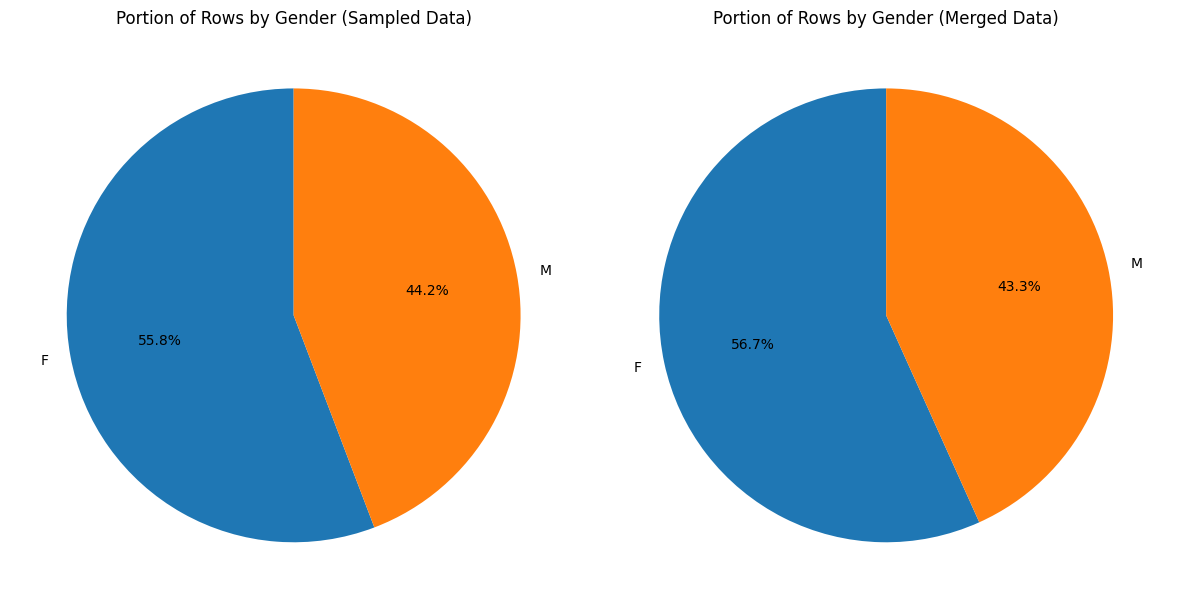

In [ ]:
# Count the occurrences of each gender in sampled_data
sampled_gender_counts = sampled_data['Patient Sex'].value_counts()

# Count the occurrences of each gender in merged_data
merged_gender_counts = merged_data['Patient Sex'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for sampled_data
sampled_gender_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=90, 
    ax=axes[0], 
    labels=sampled_gender_counts.index
)
axes[0].set_title('Portion of Rows by Gender (Sampled Data)')
axes[0].set_ylabel('')  # Remove y-axis label for better aesthetics

# Plot for merged_data
merged_gender_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=90, 
    ax=axes[1], 
    labels=merged_gender_counts.index
)
axes[1].set_title('Portion of Rows by Gender (Merged Data)')
axes[1].set_ylabel('') 

# Display the plots
plt.tight_layout()
plt.show()

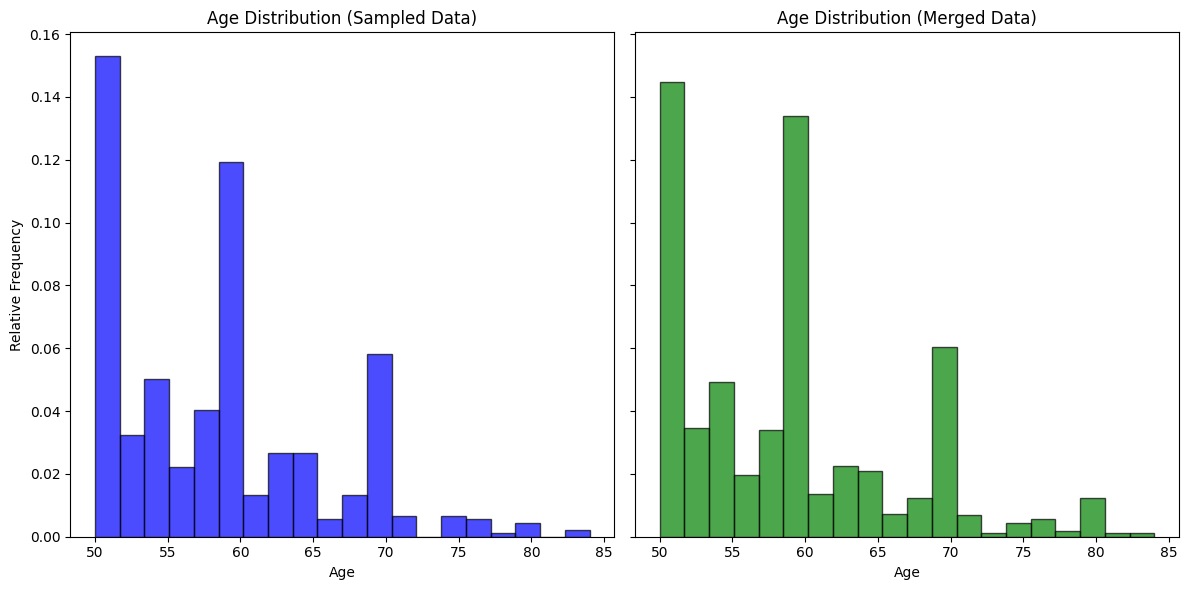

In [ ]:
# Plot the age distribution for sampled_data and merged_data with relative frequency
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for sampled_data
axes[0].hist(sampled_data['Patient Age'], bins=20, color='blue', alpha=0.7, edgecolor='black', density=True)
axes[0].set_title('Age Distribution (Sampled Data)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Relative Frequency')

# Plot for merged_data
axes[1].hist(merged_data['Patient Age'], bins=20, color='green', alpha=0.7, edgecolor='black', density=True)
axes[1].set_title('Age Distribution (Merged Data)')
axes[1].set_xlabel('Age')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

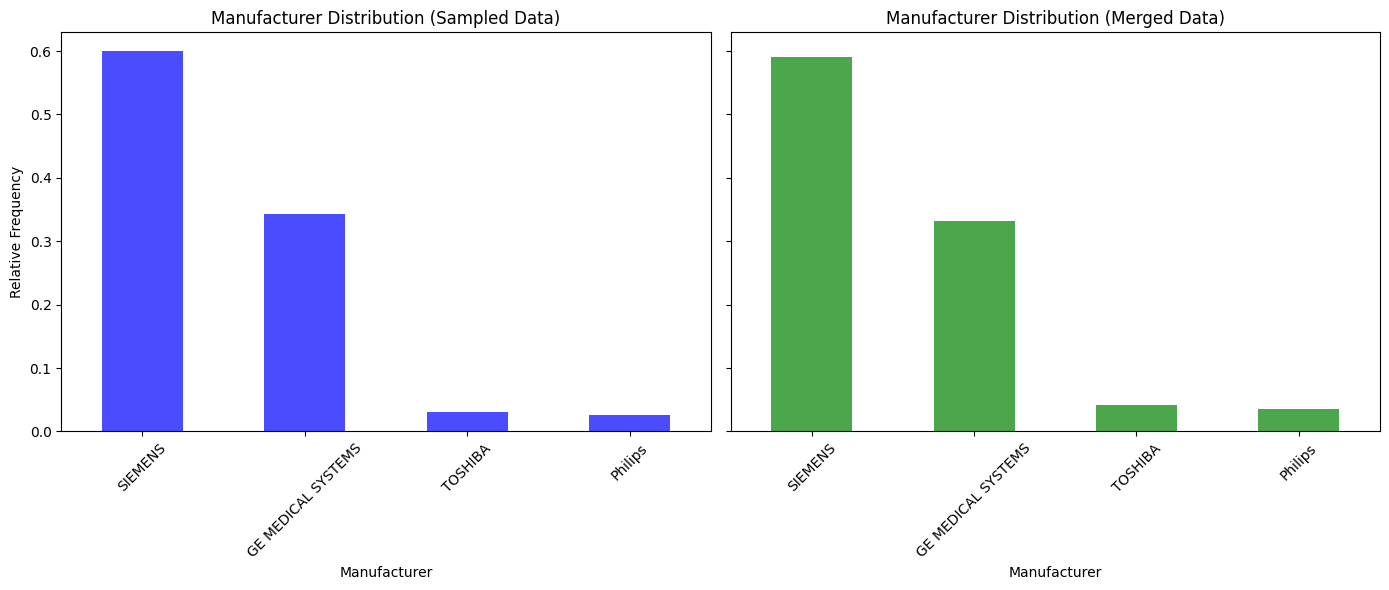

In [ ]:
# Count the occurrences of each Manufacturer in sampled_data
sampled_manufacturer_counts = sampled_data['Manufacturer'].value_counts(normalize=True)  # Normalize for relative frequency

# Count the occurrences of each Manufacturer in merged_data
merged_manufacturer_counts = merged_data['Manufacturer'].value_counts(normalize=True)  # Normalize for relative frequency

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for sampled_data
sampled_manufacturer_counts.plot(
    kind='bar', 
    color='blue', 
    alpha=0.7, 
    ax=axes[0]
)
axes[0].set_title('Manufacturer Distribution (Sampled Data)')
axes[0].set_xlabel('Manufacturer')
axes[0].set_ylabel('Relative Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot for merged_data
merged_manufacturer_counts.plot(
    kind='bar', 
    color='green', 
    alpha=0.7, 
    ax=axes[1]
)
axes[1].set_title('Manufacturer Distribution (Merged Data)')
axes[1].set_xlabel('Manufacturer')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

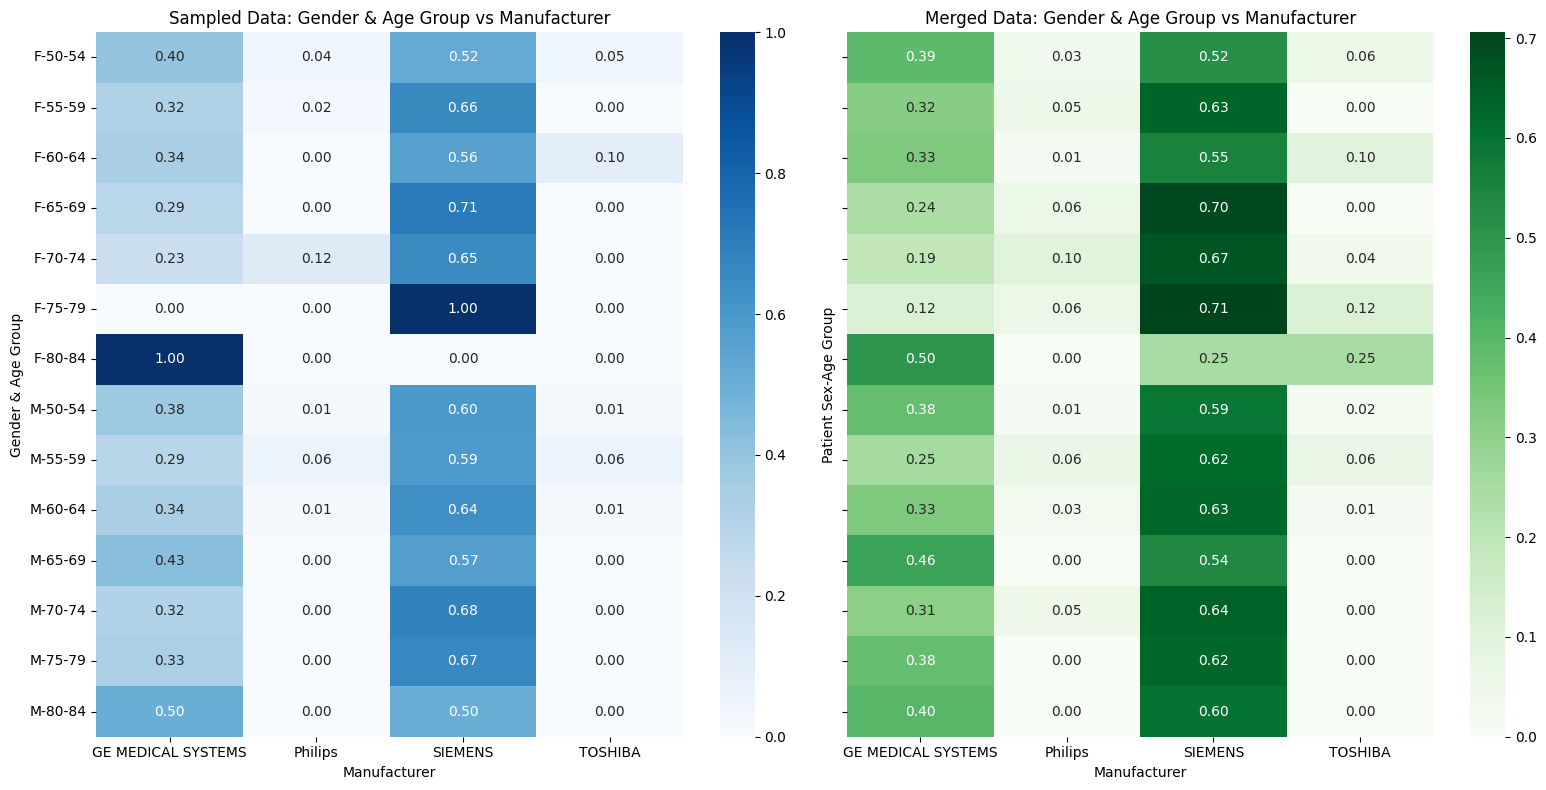

In [48]:
# Create a crosstab for sampled_data (Gender vs Manufacturer vs Age Group)
sampled_crosstab = pd.crosstab(
    [sampled_data['Patient Sex'], sampled_data['Age Group']], 
    sampled_data['Manufacturer'], 
    normalize='index'
)

# Create a crosstab for merged_data (Gender vs Manufacturer vs Age Group)
merged_crosstab = pd.crosstab(
    [merged_data['Patient Sex'], merged_data['Age Group']], 
    merged_data['Manufacturer'], 
    normalize='index'
)

# Plot the crosstabs as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Heatmap for sampled_data
sns.heatmap(sampled_crosstab, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title('Sampled Data: Gender & Age Group vs Manufacturer')
axes[0].set_xlabel('Manufacturer')
axes[0].set_ylabel('Gender & Age Group')

# Heatmap for merged_data
sns.heatmap(merged_crosstab, annot=True, fmt=".2f", cmap="Greens", ax=axes[1])
axes[1].set_title('Merged Data: Gender & Age Group vs Manufacturer')
axes[1].set_xlabel('Manufacturer')

plt.tight_layout()
plt.show()

In [ ]:
# create csv file and only keep filename
sampled_data[['name']].to_csv('filenames.csv', index=False)